In [6]:
# imports and configs

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# make plots a bit bigger
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
print(pd.options.display.max_rows)
print(pd.options.display.expand_frame_repr)
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

20
False


In [7]:
# load the datasets

df_c = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df_d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df_r = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

# next rotate them to add a Date column

ids = ['Country/Region', 'Province/State', 'Lat', 'Long']

df_c = df_c.melt(id_vars=ids, var_name="Date", value_name="Confirmed")
df_d = df_d.melt(id_vars=ids, var_name="Date", value_name="Deaths")
df_r = df_r.melt(id_vars=ids, var_name="Date", value_name="Recovered")

# next merge the Confirmed/Deaths/Recovered into one dataframe

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
keys = ["Province/State", "Country/Region", "Lat", "Long", "Date"]

df = pd.merge(df_c, df_d, how='outer', on=keys)
df = pd.merge(df, df_r, how='outer', on=keys)

# some countries have no Province/State, we need empty strings

df['Province/State'] = df['Province/State'].fillna('')

# finally cleanup the dates (who uses M/D/Y in a dataset ???)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# add an Id column

df['Id'] = df['Country/Region'] + '-' + df['Province/State']

# add Delta columns

df['ConfirmedIncrease'] = df.groupby('Id')['Confirmed'].diff()
df['DeathsIncrease'] = df.groupby('Id')['Deaths'].diff()
df['RecoveredIncrease'] = df.groupby('Id')['Recovered'].diff()

# fix column order

cols = ['Country/Region', 'Province/State', 'Id', 'Date',
        'Confirmed', 'ConfirmedIncrease',
        'Deaths', 'DeathsIncrease',
        'Recovered', 'RecoveredIncrease' ]

df = df[cols]

# sort by Confirmed column

#df = df.sort_values(by=['Date', 'Confirmed'])

# write it for review

df.to_csv("csse-combined.csv", index=False)

#for c in df.columns:
#    u = df[c].unique()
#    print("%-20s %u" % (c, len(u)))

#print(df['Country/Region'].unique())

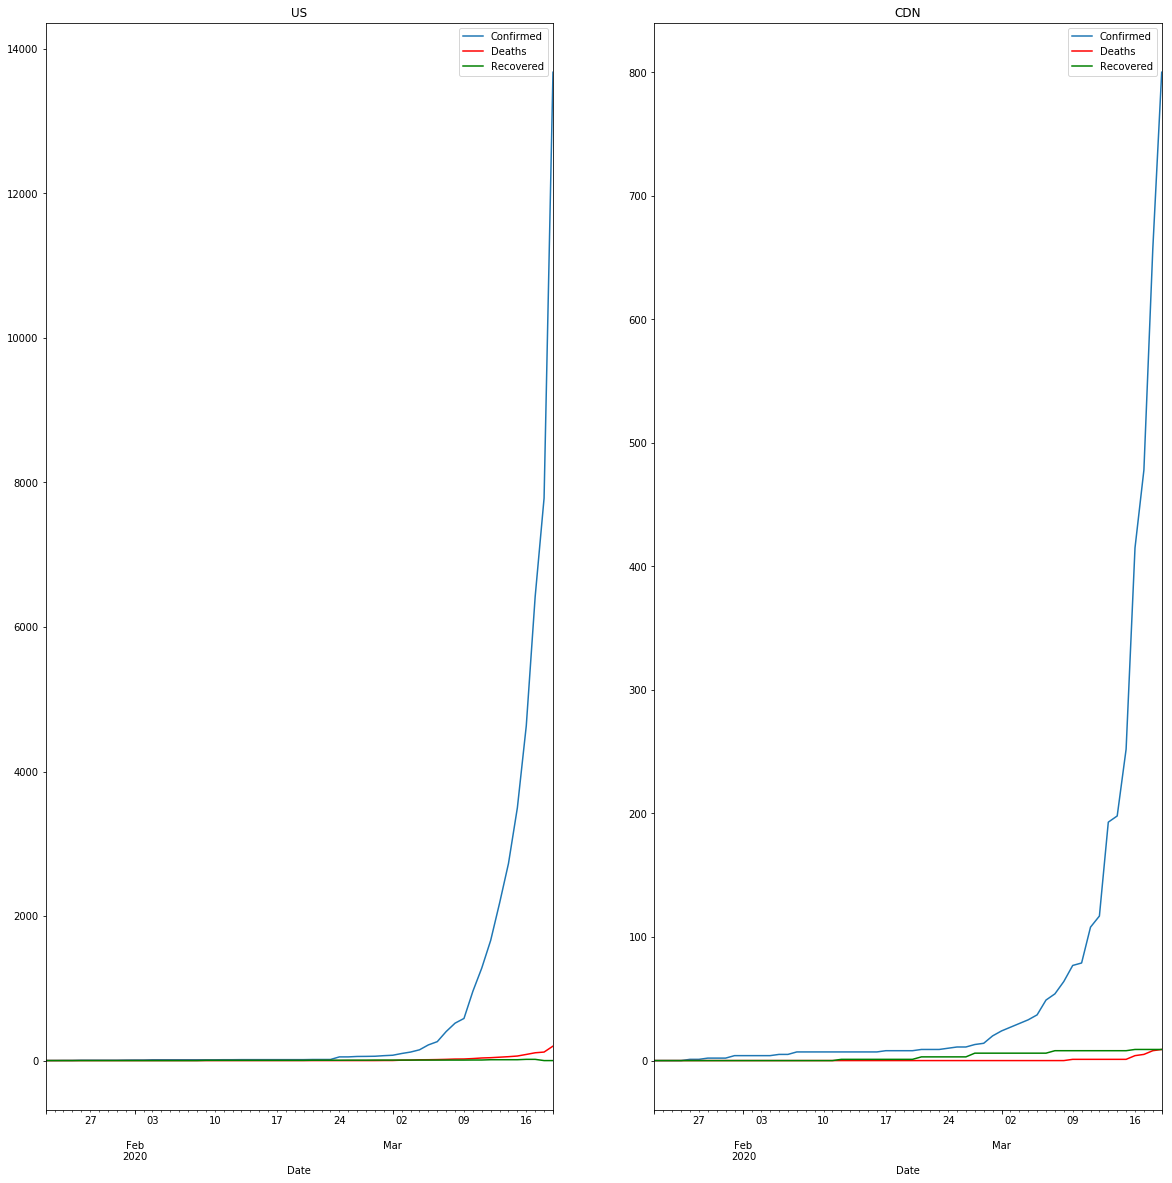

In [8]:
cdn = df.loc[df['Country/Region'] == 'Canada']
cdn = cdn.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

ont = df.loc[df['Province/State'] == 'Ontario']

usa = df.loc[df['Country/Region'] == 'US']
usa = usa.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})


#print(cdn)
#print(ont)

#p = ont
#p = cdn

fig, (ax1, ax2) = plt.subplots(1, 2)

p = usa
ax1.set_title('US')
p.plot(kind='line',x='Date',y='Confirmed',ax=ax1)
p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax1)
p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax1)

p = cdn
ax2.set_title('CDN')
p.plot(kind='line',x='Date',y='Confirmed',ax=ax2)
p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax2)
p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax2)


plt.show()


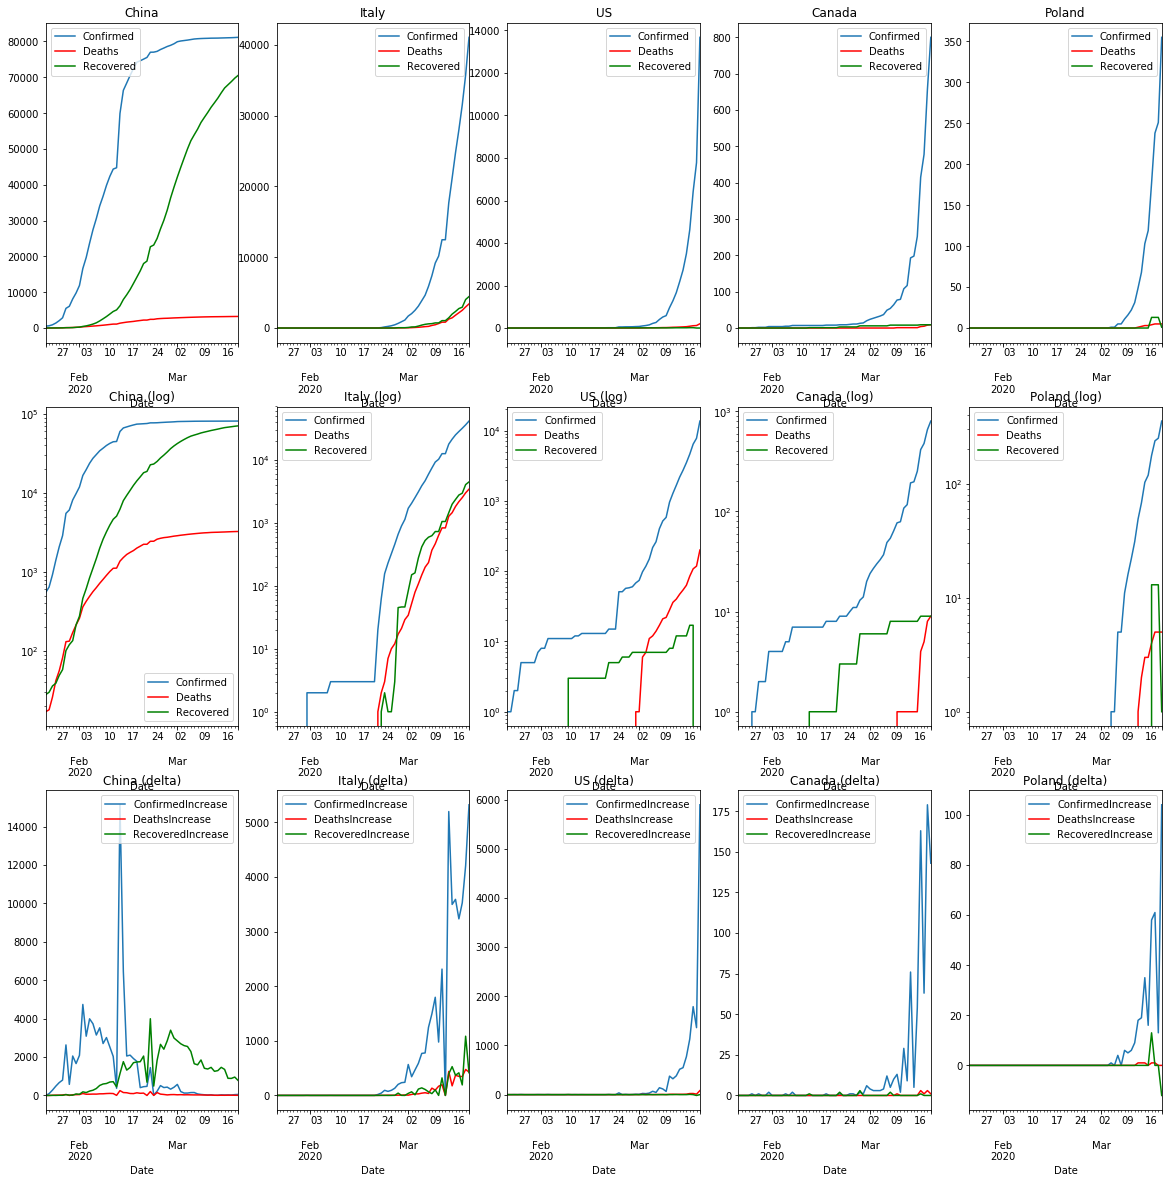

In [9]:

countries = ['China', 'Italy', 'US', 'Canada', 'Poland']

fig, axs = plt.subplots(3, len(countries))

i = 0
for country in countries:
    p = df.loc[df['Country/Region'] == country]
    p = p.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum',
                                                                 'Deaths': 'sum',
                                                                 'Recovered': 'sum',
                                                                 'ConfirmedIncrease': 'sum',
                                                                 'DeathsIncrease': 'sum',
                                                                 'RecoveredIncrease': 'sum'})

    ax = axs[0][i]
    ax.set_title(country)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)

    ax = axs[1][i]
    ax.set_title("%s (log)" % country)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)
    ax.set_yscale('log')

    ax = axs[2][i]
    ax.set_title("%s (delta)" % country)
    p.plot(kind='line',x='Date',y='ConfirmedIncrease',ax=ax)
    p.plot(kind='line',x='Date',y='DeathsIncrease', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='RecoveredIncrease', color='green', ax=ax)

    i = i + 1

fig.savefig('out/countries.png')
plt.show()


In [ ]:
country = 'Canada'
cdf = df.loc[df['Country/Region'] == country]
regions = cdf['Province/State'].unique()
regions = regions[0:5]

print(regions)

fig, axs = plt.subplots(3, len(regions))

i = 0
for region in regions:
    d = cdf.loc[df['Province/State'] == region]

    p = d.groupby(['Province/State','Date'],as_index=False).agg({'Confirmed': 'sum',
                                                                 'Deaths': 'sum',
                                                                 'Recovered': 'sum',
                                                                 'ConfirmedIncrease': 'sum',
                                                                 'DeathsIncrease': 'sum',
                                                                 'RecoveredIncrease': 'sum'})

    #print(p)
    
    ax = axs[0][i]
    ax.set_title(region)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)

    ax = axs[1][i]
    ax.set_title("%s (log)" % region)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)
    ax.set_yscale('log')

    ax = axs[2][i]
    ax.set_title("%s (delta)" % region)
    p.plot(kind='line',x='Date',y='ConfirmedIncrease',ax=ax)
    p.plot(kind='line',x='Date',y='DeathsIncrease', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='RecoveredIncrease', color='green', ax=ax)

    i = i + 1


fig.savefig('out/canada.png')
plt.show()


['British Columbia' 'Ontario' 'Alberta' 'Quebec' 'New Brunswick']
